***PARTE ANALÍTICA PARA EL TFG --> Estudio de selección aletoria de las acciones:***

**`1º paso:`** Impratar las librerías necesarias para el análisis

In [ ]:
# Importar librerias
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from tqdm import tqdm

**`2º paso:`** Cargar los datos de los tickers del S&P 500, descargar los precios ajustados de cierre de estos activos, limpieza de los datos y cálculo de los rendimientos diarios logarítmicos

In [ ]:
# Cargar los datos de los tickers del S&P 500
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))
start_date = '2014-01-01'

# Descarga de los datos ajustados de cierre de estos activos
precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

#Limpieza de los datos y cálculo de los rendimientos diarios logarítmicos
precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
ret_activos = np.log(precios_activos_sp500).diff().dropna()

[******************    38%%                      ]  193 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2014-01-01 -> 2024-05-31)


[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2014-01-01 -> 2024-05-31)')
ERROR:yfinance:['BRK.B', 'CDAY', 'PEAK', 'FLT']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


**`3º paso:`** Definición de una función para calcular los retornos y los pesos de ambas carteras

In [ ]:
# Devuelve retornos de la cartera de Mínima Volatilidad
def cartera_ret_min_vol(ret):

    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''

    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame

        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()

            #Variables de decisión
        pesos = cp.Variable(num_act)

        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]

        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve(solver=cp.ECOS) # Usar solver ECOS

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return ret @ pesos_ajustados

    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

In [ ]:
# Devuelve pesos de la cartera de Mínima Volatilidad
def cartera_min_vol(ret):

    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''

    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame

        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()

            #Variables de decisión
        pesos = cp.Variable(num_act)

        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]

        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve(solver=cp.ECOS) # Usar solver ECOS

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return pesos_ajustados

    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

In [ ]:
# Devuelve retornos cartera de Mínimo CVaR
def cartera_ret_cvar(ret, alpha=0.05):

    num_data = ret.shape[0]
    num_act = ret.shape[1]

    pesos = cp.Variable(num_act)
    t = cp.Variable()
    ui = cp.Variable(num_data)

    ret_esperados = ret.mean().values

    riesgo = t + cp.sum(ui)/(alpha * num_data)
    retornos = ret_esperados.T @ pesos

    restricciones = [
        -ret.to_numpy() @ pesos - t - ui <= 0,
        ui >= 0,
        cp.sum(pesos) == 1,
        pesos >= 0,
    ]

    objective = cp.Minimize(riesgo)

    # Solve the problem
    prob = cp.Problem(objective, restricciones)
    prob.solve(solver=cp.ECOS) # Usar solver ECOS

    pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

    return ret @ pesos_ajustados

In [ ]:
# Devuelve pesos de la cartera de Mínimo CVaR
def cartera_cvar(ret, alpha=0.05):

    num_data = ret.shape[0]
    num_act = ret.shape[1]

    pesos = cp.Variable(num_act)
    t = cp.Variable()
    ui = cp.Variable(num_data)

    ret_esperados = ret.mean().values

    riesgo = t + cp.sum(ui)/(alpha * num_data)
    retornos = ret_esperados.T @ pesos

    restricciones = [
        -ret.to_numpy() @ pesos - t - ui <= 0,
        ui >= 0,
        cp.sum(pesos) == 1,
        pesos >= 0,
    ]

    objective = cp.Minimize(riesgo)

    # Solve the problem
    prob = cp.Problem(objective, restricciones)
    prob.solve(solver=cp.ECOS) # Usar solver ECOS

    pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

    return pesos_ajustados

**`4º paso:`** Configuración y generación de carteras aleatorias

In [ ]:
# Paso 1: Extraer los nombres de los activos
nombres_activos = ret_activos.columns

# Paso 2 y 3: Generar 1000 carteras aleatorias de 50 activos cada una y calcular los retornos esperados y las volatilidades
np.random.seed(42)  # Para reproducibilidad
num_carteras = 1000
num_activos_por_cartera = 50

carteras = []
pesos_min_vol = []
pesos_cvar = []

end_train = '2020'
ret_activos_train = ret_activos.loc[:end_train]
ret_activos_test = ret_activos.loc[end_train:]

for _ in tqdm(range(num_carteras)):
    # Selección aleatoria de 50 activos
    seleccion = np.random.choice(nombres_activos, size=num_activos_por_cartera, replace=False)

    # Seleccionar los retornos de los activos de la cartera
    retornos_cartera_train = ret_activos_train[seleccion]


    # Almacenar los resultados
    carteras.append(seleccion)
    pesos_min_vol.append(cartera_min_vol (retornos_cartera_train))
    pesos_cvar.append(cartera_cvar(retornos_cartera_train))


100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


**`5º paso: `**Cálculo de los retornos de ambas carteras en un conjunto de datos de prueba

In [ ]:
# Cálculo de los retornos de ambas carteras en un conjunto de datos de prueba
ret_carteras_min_test = []
ret_carteras_cvar_test = []
for i in range(len(carteras)):
    ret_carteras_min_test.append(ret_activos_test[carteras[i]] @ pesos_min_vol[i])
    ret_carteras_cvar_test.append(ret_activos_test[carteras[i]] @ pesos_cvar[i])

**`6ª paso:`** Cálculo de las medidas de rentabilidad y riesgo, representación gráfica y cálculo de la media, el máximo y el mínimo de ambas carteras

In [ ]:
# Cálculo de las medidas de rentabilidad y riesgo de la cartera de Mínima Volatilidad
mean_ret_min_test = np.array(ret_carteras_min_test).mean(axis=1) # Retorno esperado de la cartera de Mínima Volatilidad
std_ret_min_test = np.array(ret_carteras_min_test).std(axis=1) # Volatilidad de la cartera de Mínima Volatilidad
skew_ret_min_test = [skew(arr) for arr in ret_carteras_min_test] # Asimetría de la cartera Mínima Volatilidad
kurt_ret_min_test = [kurtosis(arr) for arr in ret_carteras_min_test] # Curtosis de la cartera Mínima Volatilidad
var_ret_min_test = np.percentile(ret_carteras_min_test, 5, axis=1) # VaR de la cartera de Mínima Volatilidad
cvar_ret_min_test = np.mean([arr[arr <= var_ret_min_test[i]] for i, arr in enumerate(ret_carteras_min_test)], axis=1) # CVaR de la cartera de Mínima Volatilidad

In [ ]:
# Cálculo de las medidas de rentabilidad y riesgo de la cartera de Mínimo CVaR
mean_ret_cvar_test = np.array(ret_carteras_cvar_test).mean(axis=1) # Retorno esperado de la cartera de Mínimo CVaR
std_ret_cvar_test = np.array(ret_carteras_cvar_test).std(axis=1) # Volatilidad de la cartera de Mínimo CVaR
skew_ret_cvar_test = [skew(arr) for arr in ret_carteras_cvar_test] # Asimetría de la cartera de Mínimo CVaR
kurt_ret_cvar_test = [kurtosis(arr) for arr in ret_carteras_cvar_test] # Curtosis de la cartera de Mínimo CVaR
var_ret_cvar_test = np.percentile(ret_carteras_cvar_test, 5, axis=1) # VaR de la cartera de Mínimo CVaR
cvar_ret_cvar_test = np.mean([arr[arr <= var_ret_cvar_test[i]] for i, arr in enumerate(ret_carteras_cvar_test)], axis=1) # CVaR de la cartera de Mínimo CVaR

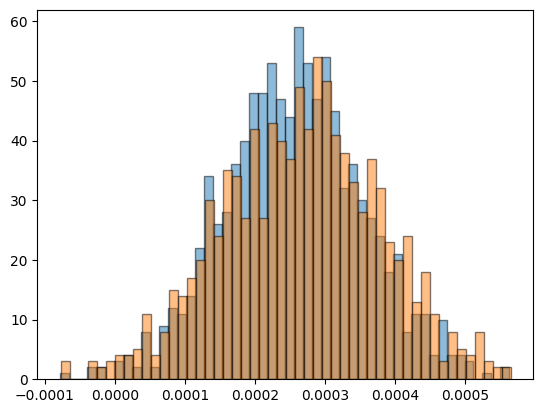

In [ ]:
# Representación gráfica de los retornos esperados de ambas carteras
plt.hist(mean_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(mean_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del retorno esperado de la cartera de mínima varianza es: {np.mean(mean_ret_min_test)}')
print(f' Media del retorno esperado de la cartera de CVaR es: {np.mean(mean_ret_cvar_test)}')

# El máximo:
print(f' Max del retorno esperado de la cartera de mínima varianza es: {np.max(mean_ret_min_test)}')
print(f' Max del retorno esperado de la cartera de CVaR es: {np.max(mean_ret_cvar_test)}')

# El mínimo:
print(f' Min del retorno esperado de la cartera de mínima varianza es: {np.min(mean_ret_min_test)}')
print(f' Min del retorno esperado de la cartera de CVaR es: {np.min(mean_ret_cvar_test)}')

 Media del retorno esperado de la cartera de mínima varianza es: 0.00025475652465119453
 Media del retorno esperado de la cartera de CVaR es: 0.0002656873284304633
 Max del retorno esperado de la cartera de mínima varianza es: 0.0005632677544161096
 Max del retorno esperado de la cartera de CVaR es: 0.0005651863265311637
 Min del retorno esperado de la cartera de mínima varianza es: -7.850765152430678e-05
 Min del retorno esperado de la cartera de CVaR es: -7.672062313682564e-05


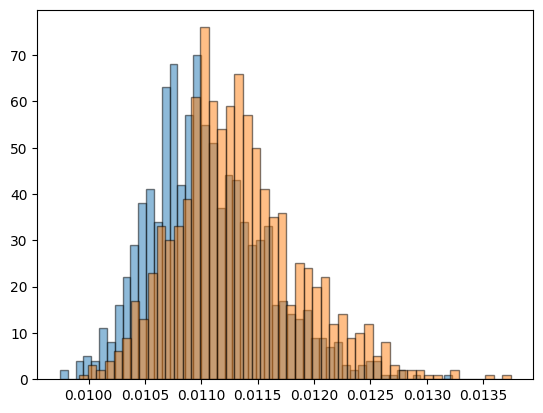

In [ ]:
# Representación gráfica de las volatilidad de ambas carteras
plt.hist(std_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(std_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la volatilidad de la cartera de mínima varianza es: {np.mean(std_ret_min_test)}')
print(f' Media de la volatilidad de la cartera de CVaR es: {np.mean(std_ret_cvar_test)}')

# El máximo:
print(f' Max de la volatilidad de la cartera de mínima varianza es: {np.max(std_ret_min_test)}')
print(f' Max de la volatilidad de la cartera de CVaR es: {np.max(std_ret_cvar_test)}')

# El mínimo:
print(f' Min de la volatilidad de la cartera de mínima varianza es: {np.min(std_ret_min_test)}')
print(f' Min de la volatilidad de la cartera de CVaR es: {np.min(std_ret_cvar_test)}')

 Media de la volatilidad de la cartera de mínima varianza es: 0.011049411997883327
 Media de la volatilidad de la cartera de CVaR es: 0.011321073597501627
 Max de la volatilidad de la cartera de mínima varianza es: 0.013222364913451946
 Max de la volatilidad de la cartera de CVaR es: 0.013745277861266496
 Min de la volatilidad de la cartera de mínima varianza es: 0.009746105047715703
 Min de la volatilidad de la cartera de CVaR es: 0.009915412809940492


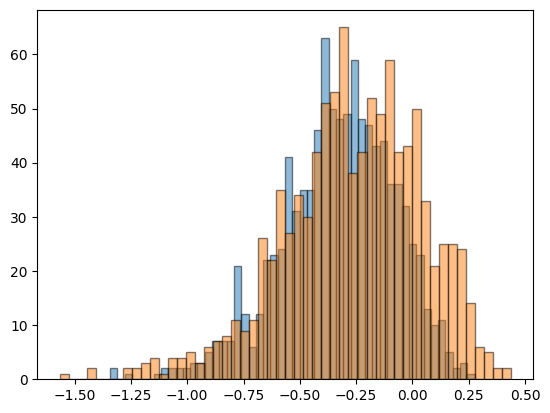

In [ ]:
# Representación gráfica de las asimetrías de ambas carteras
plt.hist(skew_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(skew_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la asimetría de la cartera de mínima varianza es: {np.mean(skew_ret_min_test)}')
print(f' Media de la asimetría de la cartera de CVaR es: {np.mean(skew_ret_cvar_test)}')

# El máximo:
print(f' Max de la asimetría de la cartera de mínima varianza es: {np.max(skew_ret_min_test)}')
print(f' Max de la asimetría de la cartera de CVaR es: {np.max(skew_ret_cvar_test)}')

# El mínimo:
print(f' Min de la asimetría de la cartera de mínima varianza es: {np.min(skew_ret_min_test)}')
print(f' Min de la asimetría de la cartera de CVaR es: {np.min(skew_ret_cvar_test)}')

 Media de la asimetría de la cartera de mínima varianza es: -0.3326264600493443
 Media de la asimetría de la cartera de CVaR es: -0.2678228548118374
 Max de la asimetría de la cartera de mínima varianza es: 0.27586520836963163
 Max de la asimetría de la cartera de CVaR es: 0.4365632834730582
 Min de la asimetría de la cartera de mínima varianza es: -1.3430808843535205
 Min de la asimetría de la cartera de CVaR es: -1.5651873001176853


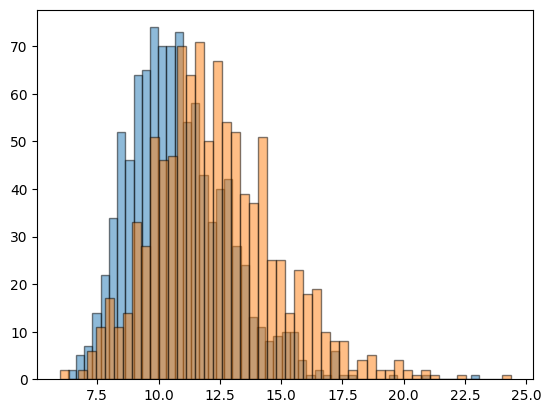

In [ ]:
# Representación gráfica de las curtosis de ambas carteras
plt.hist(kurt_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(kurt_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la curtosis de la cartera de mínima varianza es: {np.mean(kurt_ret_min_test)}')
print(f' Media de la curtosis de la cartera de CVaR es: {np.mean(kurt_ret_cvar_test)}')

# El máximo:
print(f' Max de la curtosis de la cartera de mínima varianza es: {np.max(kurt_ret_min_test)}')
print(f' Max de la curtosis de la cartera de CVaR es: {np.max(kurt_ret_cvar_test)}')

# El mínimo:
print(f' Min de la curtosis de la cartera de mínima varianza es: {np.min(kurt_ret_min_test)}')
print(f' Min de la curtosis de la cartera de CVaR es: {np.min(kurt_ret_cvar_test)}')

 Media de la curtosis de la cartera de mínima varianza es: 10.80089247996944
 Media de la curtosis de la cartera de CVaR es: 12.325133049000717
 Max de la curtosis de la cartera de mínima varianza es: 23.0840768415965
 Max de la curtosis de la cartera de CVaR es: 24.3703024771434
 Min de la curtosis de la cartera de mínima varianza es: 6.295796279888384
 Min de la curtosis de la cartera de CVaR es: 5.977672013779067


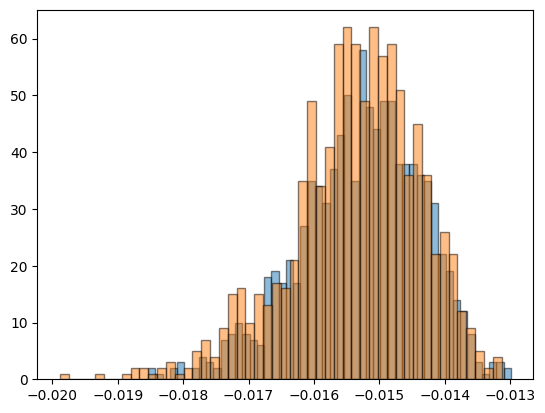

In [ ]:
# Representación gráfica de los VaR de ambas carteras
plt.hist(var_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(var_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del VaR de la cartera de mínima varianza es: {np.mean(var_ret_min_test)}')
print(f' Media del VaR de la cartera de CVaR es: {np.mean(var_ret_cvar_test)}')

# El máximo:
print(f' Max del VaR de la cartera de mínima varianza es: {np.max(var_ret_min_test)}')
print(f' Max del VaR de la cartera de CVaR es: {np.max(var_ret_cvar_test)}')

# El mínimo:
print(f' Min del VaR de la cartera de mínima varianza es: {np.min(var_ret_min_test)}')
print(f' Min del VaR de la cartera de CVaR es: {np.min(var_ret_cvar_test)}')

 Media del VaR de la cartera de mínima varianza es: -0.015285397501878059
 Media del VaR de la cartera de CVaR es: -0.015378265920003936
 Max del VaR de la cartera de mínima varianza es: -0.012987385810654922
 Max del VaR de la cartera de CVaR es: -0.01312705717757965
 Min del VaR de la cartera de mínima varianza es: -0.018534973373996733
 Min del VaR de la cartera de CVaR es: -0.019886152420950865


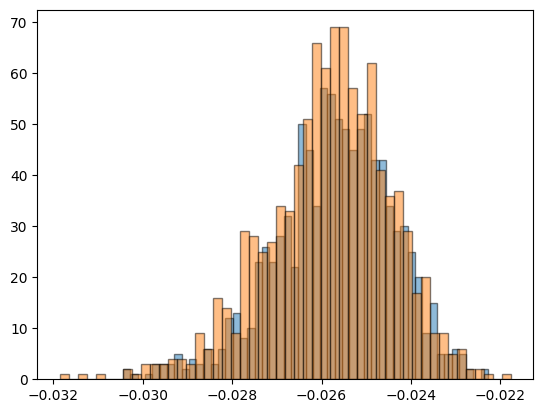

In [ ]:
# Representación gráfica de los CVaR de ambas carteras
plt.hist(cvar_ret_min_test, bins=50, edgecolor='black', alpha=0.5);
plt.hist(cvar_ret_cvar_test, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del CVaR de la cartera de mínima varianza es: {np.mean(cvar_ret_min_test)}')
print(f' Media del CVaR de la cartera de CVaR es: {np.mean(cvar_ret_cvar_test)}')

# El máximo:
print(f' Max del CVaR de la cartera de mínima varianza es: {np.max(cvar_ret_min_test)}')
print(f' Max del CVaR de la cartera de CVaR es: {np.max(cvar_ret_cvar_test)}')

# El mínimo:
print(f' Min del CVaR de la cartera de mínima varianza es: {np.min(cvar_ret_min_test)}')
print(f' Min del CVaR de la cartera de CVaR es: {np.min(cvar_ret_cvar_test)}')

 Media del CVaR de la cartera de mínima varianza es: -0.025717801423795934
 Media del CVaR de la cartera de CVaR es: -0.02584808953073567
 Max del CVaR de la cartera de mínima varianza es: -0.022277121368254802
 Max del CVaR de la cartera de CVaR es: -0.021766598569464675
 Min del CVaR de la cartera de mínima varianza es: -0.03043645385484184
 Min del CVaR de la cartera de CVaR es: -0.03185256534795109


**`7º paso:`** Se repite lo anterior pero en este caso se realiza el cálculo directo de retornos esperados

In [ ]:
# Paso 1: Extraer los nombres de los activos
nombres_activos = ret_activos.columns

# Paso 2 y 3: Generar 1000 carteras aleatorias de 50 activos cada una y calcular los retornos esperados y las volatilidades
np.random.seed(42)  # Para reproducibilidad
num_carteras = 1000
num_activos_por_cartera = 50

carteras = []
ret_min_vol = []
ret_cvar = []

for _ in tqdm(range(num_carteras)):
    # Selección aleatoria de 50 activos
    seleccion = np.random.choice(nombres_activos, size=num_activos_por_cartera, replace=False)

    # Seleccionar los retornos de los activos de la cartera
    retornos_cartera = ret_activos[seleccion]


    # Almacenar los resultados
    carteras.append(seleccion)
    ret_min_vol.append(cartera_ret_min_vol (retornos_cartera))
    ret_cvar.append(cartera_ret_cvar(retornos_cartera))



100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]


In [ ]:
# Cálculo de las medidas de rentabilidad y riesgo de la cartera de Mínima Volatilidad
mean_ret_min = np.array(ret_min_vol).mean(axis=1) # Retorno esperado de la cartera de Mínima Volatilidad
std_ret_min = np.array(ret_min_vol).std(axis=1) # Volatilidad de la cartera de Mínima Volatilidad
skew_ret_min = [skew(arr) for arr in ret_min_vol] # Asimetría de la cartera de Mínima Volatilidad
kurt_ret_min = [kurtosis(arr) for arr in ret_min_vol] # Curtosis de la cartera de Mínima Volatilidad
var_ret_min = np.percentile(ret_min_vol, 5, axis=1) # VaR de la cartera de Mínima Volatilidad
cvar_ret_min = np.mean([arr[arr <= var_ret_min[i]] for i, arr in enumerate(ret_min_vol)], axis=1) # CVaR de la cartera de Mínima Volatilidad

In [ ]:
# Cálculo de las medidas de rentabilidad y riesgo de la cartera de Mínimo CVaR
mean_cvar = np.array(ret_cvar).mean(axis=1) # Retorno esperado de la cartera de Mínimo CVaR
std_cvar = np.array(ret_cvar).std(axis=1) # Volatilidad de la cartera de Mínimo CVaR
skew_cvar = [skew(arr) for arr in ret_cvar] # Asimetría de la cartera de Mínimo CVaR
kurt_cvar = [kurtosis(arr) for arr in ret_cvar] # Curtosis de la cartera de Mínimo CVaR
var_cvar = np.percentile(ret_cvar, 5, axis=1) # VaR de la cartera de Mínimo CVaR
cvar_cvar = np.mean([arr[arr <= var_cvar[i]] for i, arr in enumerate(ret_cvar)], axis=1) # CVaR de la cartera de Mínimo CVaR

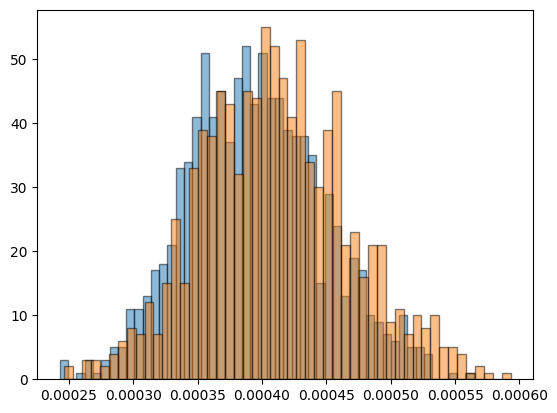

In [ ]:
# Representación gráfica de los retornos esperados de ambas carteras
plt.hist(mean_ret_min, bins=50, edgecolor='black', alpha=0.5);
plt.hist(mean_cvar, bins=50, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del retorno esperado de la cartera de mínima varianza es: {np.mean(mean_ret_min)}')
print(f' Media del retorno esperado de la cartera de CVaR es: {np.mean(mean_cvar)}')

# El máximo:
print(f' Max del retorno esperado de la cartera de mínima varianza es: {np.max(mean_ret_min)}')
print(f' Max del retorno esperado de la cartera de CVaR es: {np.max(mean_cvar)}')

# El mínimo:
print(f' Min del retorno esperado de la cartera de mínima varianza es: {np.min(mean_ret_min)}')
print(f' Min del retorno esperado de la cartera de CVaR es: {np.min(mean_cvar)}')

 Media del retorno esperado de la cartera de mínima varianza es: 0.00039397850480318906
 Media del retorno esperado de la cartera de CVaR es: 0.000410374832816535
 Max del retorno esperado de la cartera de mínima varianza es: 0.0005643869925362313
 Max del retorno esperado de la cartera de CVaR es: 0.0005932954786934049
 Min del retorno esperado de la cartera de mínima varianza es: 0.00024298093428319853
 Min del retorno esperado de la cartera de CVaR es: 0.00024628252110781744


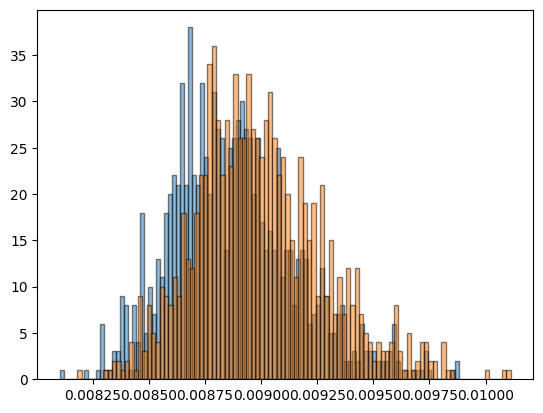

In [ ]:
# Representación gráfica de las volatilidades de ambas carteras
plt.hist(std_ret_min, bins=100, edgecolor='black', alpha=0.5);
plt.hist(std_cvar, bins=100, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la volatilidad de la cartera de mínima varianza es: {np.mean(std_ret_min)}')
print(f' Media de la volatilidad de la cartera de CVaR es: {np.mean(std_cvar)}')

# El máximo:
print(f' Max de la volatilidad de la cartera de mínima varianza es: {np.max(std_ret_min)}')
print(f' Max de la volatilidad de la cartera de CVaR es: {np.max(std_cvar)}')

# El mínimo:
print(f' Min de la volatilidad de la cartera de mínima varianza es: {np.min(std_ret_min)}')
print(f' Min de la volatilidad de la cartera de CVaR es: {np.min(std_cvar)}')

 Media de la volatilidad de la cartera de mínima varianza es: 0.008873938166835314
 Media de la volatilidad de la cartera de CVaR es: 0.008994945369308454
 Max de la volatilidad de la cartera de mínima varianza es: 0.009883762084325835
 Max de la volatilidad de la cartera de CVaR es: 0.010112524654712726
 Min de la volatilidad de la cartera de mínima varianza es: 0.008103023325208458
 Min de la volatilidad de la cartera de CVaR es: 0.008180733912429225


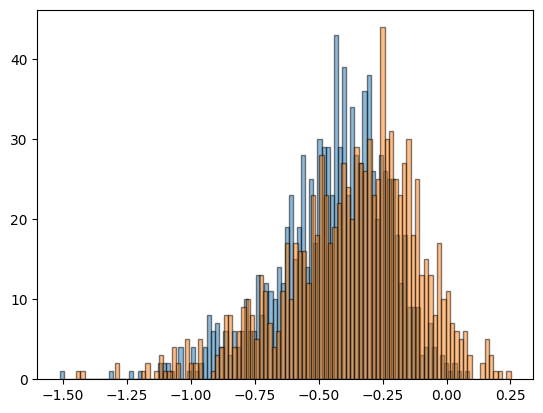

In [ ]:
# Representación gráfica de las asimetrías de ambas carteras
plt.hist(skew_ret_min, bins=100, edgecolor='black', alpha=0.5);
plt.hist(skew_cvar, bins=100, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la asimetría de la cartera de mínima varianza es: {np.mean(skew_ret_min)}')
print(f' Media de la asimetría de la cartera de CVaR es: {np.mean(skew_cvar)}')

# El máximo:
print(f' Max de la asimetría de la cartera de mínima varianza es: {np.max(skew_ret_min)}')
print(f' Max de la asimetría de la cartera de CVaR es: {np.max(skew_cvar)}')

# El mínimo:
print(f' Min de la asimetría de la cartera de mínima varianza es: {np.min(skew_ret_min)}')
print(f' Min de la asimetría de la cartera de CVaR es: {np.min(skew_cvar)}')

 Media de la asimetría de la cartera de mínima varianza es: -0.44762234911634075
 Media de la asimetría de la cartera de CVaR es: -0.3734193383584411
 Max de la asimetría de la cartera de mínima varianza es: 0.08695267302155262
 Max de la asimetría de la cartera de CVaR es: 0.2512288385186594
 Min de la asimetría de la cartera de mínima varianza es: -1.5110929156770805
 Min de la asimetría de la cartera de CVaR es: -1.4485464610908645


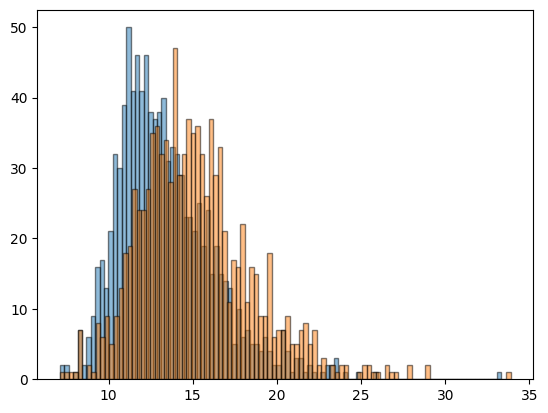

In [ ]:
# Representación gráfica de las curtosis de ambas carteras
plt.hist(kurt_ret_min, bins=100, edgecolor='black', alpha=0.5);
plt.hist(kurt_cvar, bins=100, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media de la curtosis de la cartera de mínima varianza es: {np.mean(kurt_ret_min)}')
print(f' Media de la curtosis de la cartera de CVaR es: {np.mean(kurt_cvar)}')

# El máximo:
print(f' Max de la curtosis de la cartera de mínima varianza es: {np.max(kurt_ret_min)}')
print(f' Max de la curtosis de la cartera de CVaR es: {np.max(kurt_cvar)}')

# El mínimo:
print(f' Min de la curtosis de la cartera de mínima varianza es: {np.min(kurt_ret_min)}')
print(f' Min de la curtosis de la cartera de CVaR es: {np.min(kurt_cvar)}')

 Media de la curtosis de la cartera de mínima varianza es: 13.425584951445343
 Media de la curtosis de la cartera de CVaR es: 15.18376140526485
 Max de la curtosis de la cartera de mínima varianza es: 33.3373949842795
 Max de la curtosis de la cartera de CVaR es: 33.891579704299254
 Min de la curtosis de la cartera de mínima varianza es: 7.114466348850561
 Min de la curtosis de la cartera de CVaR es: 7.112520039815298


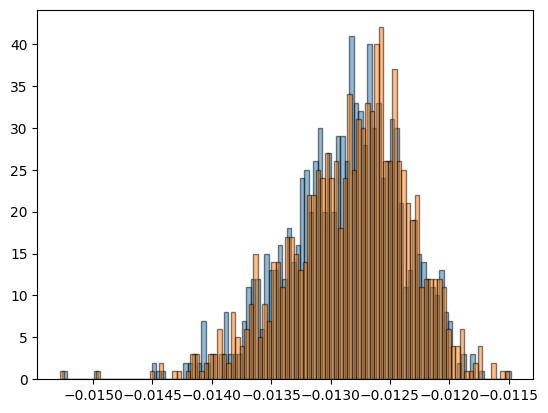

In [ ]:
# Representación gráfica de los VaR de ambas carteras
plt.hist(var_ret_min, bins=100, edgecolor='black', alpha=0.5);
plt.hist(var_cvar, bins=100, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del VaR de la cartera de mínima varianza es: {np.mean(var_ret_min)}')
print(f' Media del VaR de la cartera de CVaR es: {np.mean(var_cvar)}')

# El máximo:
print(f' Max del VaR de la cartera de mínima varianza es: {np.max(var_ret_min)}')
print(f' Max del VaR  de la cartera de CVaR es: {np.max(var_cvar)}')

# El mínimo:
print(f' Min del VaR  de la cartera de mínima varianza es: {np.min(var_ret_min)}')
print(f' Min del VaR  de la cartera de CVaR es: {np.min(var_cvar)}')

 Media del VaR de la cartera de mínima varianza es: -0.012887290578713123
 Media del VaR de la cartera de CVaR es: -0.012833739458163134
 Max del VaR de la cartera de mínima varianza es: -0.011482718932648002
 Max del VaR  de la cartera de CVaR es: -0.011496284902153427
 Min del VaR  de la cartera de mínima varianza es: -0.015258624844389888
 Min del VaR  de la cartera de CVaR es: -0.015278605269855477


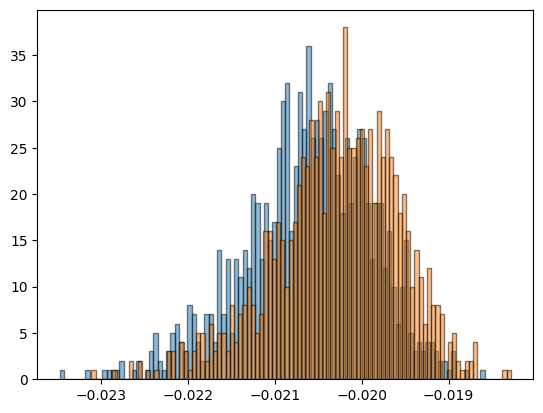

In [ ]:
# Representación gráfica de los CVaR de ambas carteras
plt.hist(cvar_ret_min, bins=100, edgecolor='black', alpha=0.5);
plt.hist(cvar_cvar, bins=100, edgecolor='black', alpha=0.5);

In [ ]:
# La media:
print(f' Media del CVaR de la cartera de mínima varianza es: {np.mean(cvar_ret_min)}')
print(f' Media del CVaR de la cartera de CVaR es: {np.mean(cvar_cvar)}')

# El máximo:
print(f' Max de la curtosis de la cartera de mínima varianza es: {np.max(cvar_ret_min)}')
print(f' Max de la curtosis de la cartera de CVaR es: {np.max(cvar_cvar)}')

# El mínimo:
print(f' Min de la curtosis de la cartera de mínima varianza es: {np.min(cvar_ret_min)}')
print(f' Min de la curtosis de la cartera de CVaR es: {np.min(cvar_cvar)}')

 Media del CVaR de la cartera de mínima varianza es: -0.020622606489651685
 Media del CVaR de la cartera de CVaR es: -0.02029800300733699
 Max de la curtosis de la cartera de mínima varianza es: -0.01858438813601146
 Max de la curtosis de la cartera de CVaR es: -0.018284450956037562
 Min de la curtosis de la cartera de mínima varianza es: -0.02347541926002664
 Min de la curtosis de la cartera de CVaR es: -0.023112648857946075
